# Tasca Feature Engineering

Roger Gallart - 29 maig 2021

## Preprocessament del dataset

Utilitzarem aquest dataset de Kaggle que inclou els atlètes i resultats durant 120 anys de jocs olímpics

https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results

Atributs:

- ID - Unique number for each athlete
- Name - Athlete's name
- Sex - M or F
- Age - Integer
- Height - In centimeters
- Weight - In kilograms
- Team - Team name
- NOC - National Olympic Committee 3-letter code
- Games - Year and season
- Year - Integer
- Season - Summer or Winter
- City - Host city
- Event - Event
- Sport - Sport
- SportCategory - Category type for that Sport
- SportGenre - M/F/Mixed
- Medal - Gold, Silver, Bronze, or NA

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

In [2]:
# Tipus categòric ordenat (ordinal) per les medalles
medal_type = pd.CategoricalDtype(categories=["None", "Bronze", "Silver", "Gold"], ordered=True)

# Importació del dataset (ja l'haviem pre-processat en una tasca anterior)
df = pd.read_csv('/content/drive/MyDrive/ITAcademy/datasets/120-years-olympic-results_clean.csv', 
                 index_col='ID',
                 dtype={'Medal':medal_type,
                        'Sex': 'category',
                        'Season': 'category'})

In [3]:
df.sample(7)

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Event,Sport,SportCategory,SportGenre,Medal
ID,,,,,,,,,,,,,,,,
115824,Anders Strm,M,26.0,NaN,NaN,Sweden,SWE,1928 Winter,1928,Winter,Sankt Moritz,Cross Country Skiing Men's 50 kilometres,Cross Country Skiing,50 kilometres,M,None
38632,Luis Rigiberto Garca Jimnez,M,26.0,169.0,67.0,Venezuela,VEN,1960 Summer,1960,Summer,Roma,"Fencing Men's Foil, Individual",Fencing,"Foil, Individual",M,None
24771,"Gabriela ""Gaby"" Dabrowski",F,24.0,175.0,84.0,Canada,CAN,2016 Summer,2016,Summer,Rio de Janeiro,Tennis Women's Doubles,Tennis,Doubles,F,None
28059,Marco di Carli,M,19.0,189.0,78.0,Germany,GER,2004 Summer,2004,Summer,Athina,Swimming Men's 100 metres Backstroke,Swimming,100 metres Backstroke,M,None
37000,Bertus Johannes Freese,M,26.0,NaN,NaN,Netherlands,NED,1928 Summer,1928,Summer,Amsterdam,Football Men's Football,Football,-,M,None
91031,Francesco Panetta,M,21.0,175.0,64.0,Italy,ITA,1984 Summer,1984,Summer,Los Angeles,"Athletics Men's 10,000 metres",Athletics,"10,000 metres",M,None
102022,Peter Rhle,M,27.0,193.0,90.0,West Germany,FRG,1984 Summer,1984,Summer,Los Angeles,Water Polo Men's Water Polo,Water Polo,-,M,Bronze


Imaginem que volguessim crear un model de ML per predir si un atleta guanyarà medalla d'or, argent o bronze o cap medalla en unes futures olimpiades donades les seves característiques físiques (Sex, Age, Height, Weight), el seu país (NOC) i el tipus d'esport en el que competeix (Sport).

In [4]:
# Creem un dataset amb els atributs que ens interessen
df_raw = df[['Age','Sex','Height','Weight','NOC', 'Sport', 'Medal']].copy()

In [5]:
# Mirem missing values
df_raw.isna().sum()

Age        9474
Sex           0
Height    60171
Weight    62875
NOC           0
Sport         0
Medal         0
dtype: int64

## Exercici 1
Agafa un conjunt de dades de tema esportiu que t'agradi i normalitza els atributs categòrics en dummy. Normalitza els atributs numèrics amb StandardScaler.

Per fer-ho de la manera més general i escalable possible, posarem les transformacions en Pipelines, com si fos un projecte real.

In [6]:
# Columna Target
targ_column = ['Medal']
print(f'The target column is: {targ_column}')

# Columnes Numèriques
num_columns = list(df_raw.select_dtypes('number').columns)
print(f"Numerical columns are: {num_columns}")

# Columnes Categòriques (= les que no són numèriques i que no són el target)
cat_columns = list(set(df_raw.columns) - set(num_columns) - set(targ_column))
print(f"Categorical columns are: {cat_columns}")


The target column is: ['Medal']
Numerical columns are: ['Age', 'Height', 'Weight']
Categorical columns are: ['Sport', 'NOC', 'Sex']


In [7]:
# Pipeline per atributs numèrics:
#   - Substituim els NaN per la mediana
#   - Estandaritzem utilitzant StandardScaler()

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', StandardScaler())])

# Pipeline per atributs categòrics
#   - Codifiquem variables categòriques utilitzant OneHotEncoding
cat_pipe = Pipeline([('ohe', OneHotEncoder(sparse=False))])


# Combinem els dos pipelines
preprocessor = ColumnTransformer(transformers=[('num_transf', num_pipe, num_columns),
                                               ('cat_transf', cat_pipe, cat_columns),
                                               ])

X = preprocessor.fit_transform(df_raw);

In [8]:
# Guardem el nom de les noves columnes
cat_columns_new = preprocessor.named_transformers_['cat_transf']['ohe'].get_feature_names(cat_columns).tolist()
columns = num_columns + cat_columns_new

In [9]:
df_X = pd.DataFrame(X, columns=columns)
df_X.head()

,Age,Height,Weight,Sport_Aeronautics,Sport_Alpine Skiing,Sport_Alpinism,Sport_Archery,Sport_Art Competitions,Sport_Athletics,Sport_Badminton,Sport_Baseball,Sport_Basketball,Sport_Basque Pelota,Sport_Beach Volleyball,Sport_Biathlon,Sport_Bobsleigh,Sport_Boxing,Sport_Canoeing,Sport_Cricket,Sport_Croquet,Sport_Cross Country Skiing,Sport_Curling,Sport_Cycling,Sport_Diving,Sport_Equestrianism,Sport_Fencing,Sport_Figure Skating,Sport_Football,Sport_Freestyle Skiing,Sport_Golf,Sport_Gymnastics,Sport_Handball,Sport_Hockey,Sport_Ice Hockey,Sport_Jeu De Paume,Sport_Judo,Sport_Lacrosse,Sport_Luge,Sport_Military Ski Patrol,Sport_Modern Pentathlon,...,NOC_SVK,NOC_SWE,NOC_SWZ,NOC_SYR,NOC_TAN,NOC_TCH,NOC_TGA,NOC_THA,NOC_TJK,NOC_TKM,NOC_TLS,NOC_TOG,NOC_TPE,NOC_TTO,NOC_TUN,NOC_TUR,NOC_TUV,NOC_UAE,NOC_UAR,NOC_UGA,NOC_UKR,NOC_UNK,NOC_URS,NOC_URU,NOC_USA,NOC_UZB,NOC_VAN,NOC_VEN,NOC_VIE,NOC_VIN,NOC_VNM,NOC_WIF,NOC_YAR,NOC_YEM,NOC_YMD,NOC_YUG,NOC_ZAM,NOC_ZIM,Sex_F,Sex_M
0,-0.238971,0.510420,0.752137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.398020,-0.567265,-0.837921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.238971,-0.028423,-0.042892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.351524,-0.028423,-0.042892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.716119,1.049262,0.911143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Exercici 2
Continua amb el conjunt de dades de tema esportiu que t'agradi i aplica l'anàlisi de components principals.

Apliquem PCA a les variables numèriques: Age, Height, Weight

In [10]:
# Principal Component analysis aplicat a les variables numèriques

N_COMPONENTS = 3

pca = PCA(n_components=N_COMPONENTS)
X_pca = pca.fit_transform(X[:,0:3])

pca_columns = [f'PCA_{x}' for x in range(1, N_COMPONENTS+1)]

df_pca = pd.DataFrame(X_pca, columns=pca_columns)
df_pca['Medal'] = df_raw[targ_column].to_numpy() # Afegim columna del target
df_pca.sample(7)

,PCA_1,PCA_2,PCA_3,Medal
1190,-1.906185,0.022423,0.013483,None
234157,-0.729693,0.070950,-0.231387,Bronze
7819,-1.042919,-0.119942,1.049245,None
248029,0.912551,4.271512,-0.226469,None
201533,-0.101798,-0.222239,0.001287,None
83506,1.515734,-0.250366,0.208228,None
123205,-0.912559,-0.042955,-0.072206,None


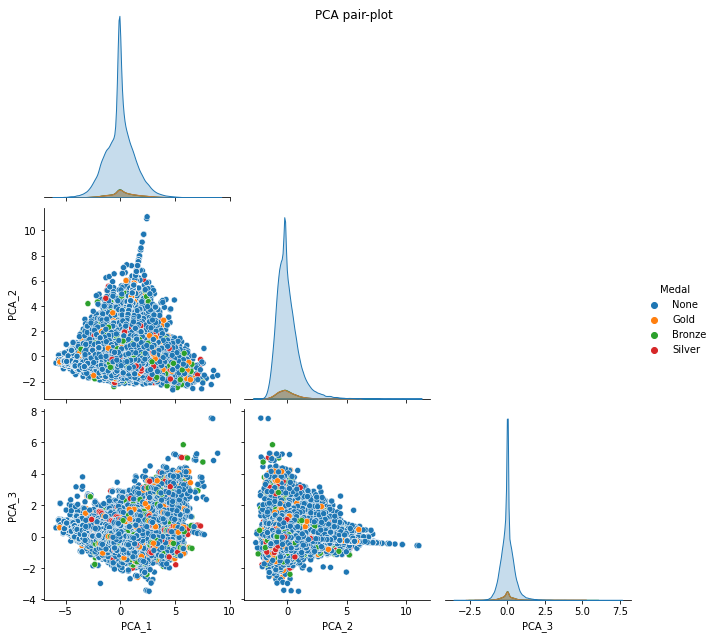

In [11]:
# PCA pair-plot
foo = sns.pairplot(df_pca, hue='Medal', corner=True, height=3)
foo.fig.suptitle('PCA pair-plot');

In [12]:
# Explained variance ratio
print(f'Explained variance ratio:')
print(*[f'PCA{i+1}: {100*x:.3f}%' for i, x in enumerate(pca.explained_variance_ratio_)], sep=', ')

Explained variance ratio:
PCA1: 60.958%, PCA2: 31.993%, PCA3: 7.048%


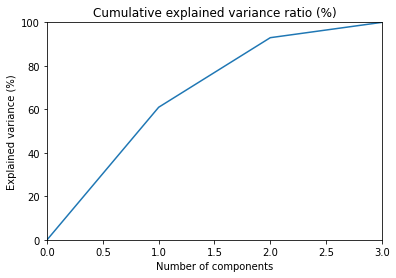

In [13]:
# Cumulative explained variance ratio
x = range(0,4)
y = np.pad(np.cumsum(pca.explained_variance_ratio_), (1,0))*100
plt.plot(x,y)
plt.xlim(0,3);
plt.ylim(0,100);
plt.xlabel('Number of components');
plt.title('Cumulative explained variance ratio (%)');
plt.ylabel('Explained variance (%)');

Veiem que PCA no ens permet reduir el nombre d'atributs, ja que calen al menys dues de les variables numèriquesper poder explicar al menys 93% de la variabilitat. Reduir de 3 a 2 variables no val la pena. En el gràfic pair-plot també podem veure que efectivament cap de les 3 components aporta cap millora en la separació d'atletes segons el tipus de medalla. Cosa que té sentit ja que no estem tenint en compte cap de les altres variables categòriques (esport, país, gènere) que previsiblement han de tenir molta influència. 

## Exercici 3
Continua amb el conjunt de dades de tema esportiu que t'agradi i normalitza les dades tenint en compte els outliers.

Analitzem els outliers que contenen els atributs Age, Height i Weight.

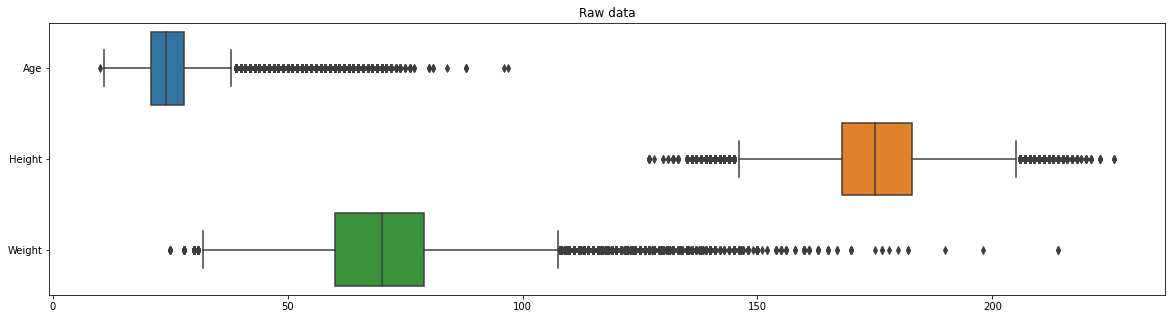

In [14]:
plt.figure(figsize=(20,5))

sns.boxplot(data=df_raw[['Age','Height','Weight']], orient='h');
plt.title('Raw data');

In [15]:
foo = df_raw[['Age','Height','Weight']]
foo.describe()

,Age,Height,Weight
count,261642.000000,210945.000000,208241.000000
mean,25.556898,175.338970,70.702393
std,6.393561,10.518462,14.348020
min,10.000000,127.000000,25.000000
25%,21.000000,168.000000,60.000000
50%,24.000000,175.000000,70.000000
75%,28.000000,183.000000,79.000000
max,97.000000,226.000000,214.000000


In [16]:
Q1 = foo.quantile(0.25)
Q3 = foo.quantile(0.75)
IQR = Q3 - Q1

outliers_bool = (foo < (Q1 - 1.5 * IQR)) |(foo > (Q3 + 1.5 * IQR))
outliers_abs = outliers_bool.sum(axis=0)
outliers_perc = outliers_abs * 100 / foo.dropna().count(axis=0)

print(f'Number of outliers:\n{outliers_abs}\n')
print(f'Percentage of outliers:\n{outliers_perc}')


Number of outliers:
Age       10317
Height     1338
Weight     3237
dtype: int64

Percentage of outliers:
Age       5.004244
Height    0.648995
Weight    1.570102
dtype: float64


Si volem tenir en compte els outliers a l'hora d'escalar les dades, en el moment d'estandaritzar les variables numèriques, existeixen bàsicament tres estratègies:
- eliminar els outliers (**no s'aconsella**, sobretot en aquest cas on sembla que NO corresponen a errors de mesura o de recol·lecció de dades, sinó a dades REALS encara que estadísticament molt poc freqüents, e.g. atletes de 90 anys o de 10 anys). Una possible estratègia seria per exemple descartar totes les dades anteriors a 1950, ja que les olimpiades anteriors a la segona guerra mundial eren molt diferents a les olimpiades actuals en quant a esports i tipologia de participants (edats, etc).

- utilitzar un 'scaler' (transformació lineal) com StandardScaler pèro més robust en front dels outliers. Es tracta de **RobustScaler()** que utilitza la mediana i el IQR (enlloc de la mitjana i desviació estàndar).

- utilitzar un 'transformer' (transformació no lineal), com per exemple **PowerTransformer()** que permet mapejar les dades a una distribució normal.

### RobustScaler()

In [17]:
# Pipeline per atributs numèrics
num_pipe_robust = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', RobustScaler(with_centering=True, with_scaling=True))])

# Pipeline per atributs categòrics
cat_pipe = Pipeline([('ohe', OneHotEncoder(sparse=False))])


# Combinem els dos pipelines
preprocessor = ColumnTransformer(transformers=[('num_transf', num_pipe_robust, num_columns),
                                               ('cat_transf', cat_pipe, cat_columns)
                                               ])

X = preprocessor.fit_transform(df_raw);

df_X_robust = pd.DataFrame(X, columns=columns)
df_X_robust[['Age','Height','Weight']].head()

,Age,Height,Weight
0,0.000000,0.5,0.833333
1,-0.166667,-0.5,-0.833333
2,0.000000,0.0,0.000000
3,1.666667,0.0,0.000000
4,-0.500000,1.0,1.000000


### PowerTransformer()

In [18]:
# Pipeline per atributs numèrics
num_pipe_robust = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('power_transf', PowerTransformer(method='box-cox'))])

# Pipeline per atributs categòrics
cat_pipe = Pipeline([('ohe', OneHotEncoder(sparse=False))])


# Combinem els dos pipelines
preprocessor = ColumnTransformer(transformers=[('num_transf', num_pipe_robust, num_columns),
                                               ('cat_transf', cat_pipe, cat_columns)
                                               ])

X = preprocessor.fit_transform(df_raw);
df_X_trans = pd.DataFrame(X, columns=columns)
df_X_trans[['Age','Height','Weight']].head()

,Age,Height,Weight
0,-0.085008,0.512614,0.804284
1,-0.286125,-0.565144,-0.837925
2,-0.085008,-0.025382,0.038288
3,1.366166,-0.025382,0.038288
4,-0.735292,1.048899,0.946647


Podem comparar gràficament les dades originals i les dades preprocessades utilitzant StandardScaler, RobustScaler i PowerTransform

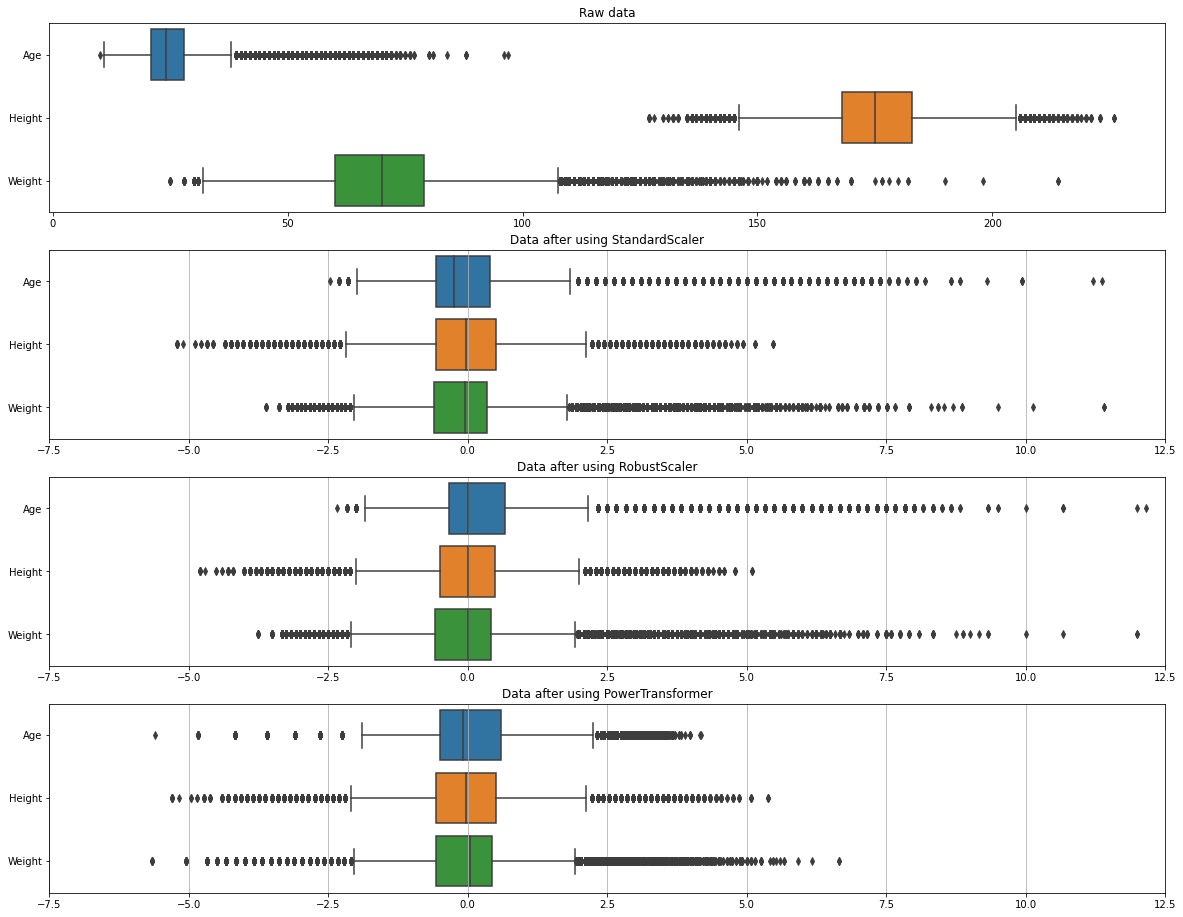

In [19]:
plt.figure(figsize=(20,16))

plt.subplot(4,1,1)
sns.boxplot(data=df_raw[['Age','Height','Weight']], orient='h');
plt.title('Raw data')

plt.subplot(4,1,2)
sns.boxplot(data=df_X[['Age','Height','Weight']], orient='h');
plt.xlim(-7.5, 12.5);
plt.title('Data after using StandardScaler')
plt.grid(axis='x')

plt.subplot(4,1,3)
sns.boxplot(data=df_X_robust[['Age','Height','Weight']], orient='h');
plt.xlim(-7.5, 12.5);
plt.title('Data after using RobustScaler')
plt.grid(axis='x')

plt.subplot(4,1,4)
sns.boxplot(data=df_X_trans[['Age','Height','Weight']], orient='h');
plt.xlim(-7.5, 12.5);
plt.title('Data after using PowerTransformer')
plt.grid(axis='x')


Veiem que no hi ha gaire diferència en el resultat obtingut amb RobustScaler i StandardScaler. En canvi amb la transformació no-lineal PowerTransform si que  s'obté una distribució més simètrica i amb menys variabilitat que les altres.



---



In [20]:
# Resum dels packages utilitzats
!pip install session_info &> /dev/null
import session_info
session_info.show()